# Лабораторная работа 2: «Разработка сверточной нейронной сети с использованием PyTorch»

## Цели работы

**Цель** —разработать и обучить сверточную нейронную сеть для задачи классификации изображений на наборе данных [Cifar-10](https://www.cs.toronto.edu/~kriz/cifar.html) с использованием  PyTorch. 

## Требования к результатам выполнения работы

1. Требования к структуре и содержимому Jupyter Notebook:
    - Загрузить и проверить данные (необходимо обеспечить демонстрацию избранных изображений и меток классов для подтверждения корректности загрузки и совпадения размерностей).
    - Реализовать архитектуру нейронной сеть с использованием фреймворка PyTorch.
    - Настроить гиперпараметры обучения (например, архитектуры, скорости обучения и размера пачки (batch size)).
    - Вывести ошибку классификации и точность на тренировочном наборе данных по окончании каждой эпохи.
    - Вывести ошибку классификации на тестовом наборе данных и построить график ошибки обучения после обучения.

2. Выбор архитектуры:
    - Необходимо использовать ***сверточные*** архитектуры нейронных сетей
    - Разрешается использовать как готовые архитектуры (например, VGG, ResNet и тд), так и архитектуры разработанные студентом самостоятельно. 
    - Реализация должна быть выполнена с нуля в PyTorch, без использования готовых модулей (например, import Resnet недопустимо).

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

In [20]:
BACTH_SIZE = 64

Files already downloaded and verified
Files already downloaded and verified


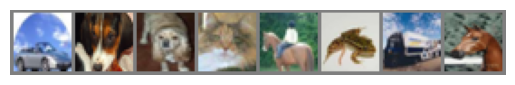

  car   dog   dog   cat horse  frog truck horse


In [21]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='/work/cifar', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='/work/cifar', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BACTH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BACTH_SIZE, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[0:8]))
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

In [22]:
print(f"Images shape:", images.shape)
print(f"Images min, mean, max:", torch.min(images), torch.mean(images), torch.max(images))
print(labels)

Images shape: torch.Size([64, 3, 32, 32])
Images min, mean, max: tensor(-1.) tensor(-0.0612) tensor(1.)
tensor([1, 5, 5, 3, 7, 6, 9, 7, 4, 1, 6, 0, 9, 7, 5, 4, 5, 7, 6, 9, 6, 4, 2, 2,
        5, 0, 7, 4, 3, 7, 2, 5, 1, 5, 1, 2, 5, 3, 1, 1, 9, 4, 3, 9, 5, 4, 2, 9,
        5, 1, 7, 9, 6, 6, 7, 5, 0, 1, 2, 7, 3, 2, 5, 9])


In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VGGInspired(nn.Module):
    def __init__(self):
        super(VGGInspired, self).__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

In [24]:
device = torch.device("cuda")
model = VGGInspired().to(device=device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.8, patience=3, min_lr=0.0001)

In [25]:
num_epochs = 50
best_accuracy = 0.0
test_accuracy_list = []
test_error_list = []

for epoch in range(num_epochs):
    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print("_________________")
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_accuracy = correct / total
    loss = total_loss/len(train_loader)
    print("Training:")
    print(f" - Training Accuracy: {train_accuracy:.4f}")
    print(f" - Loss: {loss:.4f}")

    model.eval()

    test_correct = 0
    test_total = 0
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            test_loss = criterion(outputs, labels).item()
    test_loss /= len(test_loader)

    test_accuracy = test_correct / test_total
    test_accuracy_list.append(test_accuracy)
    test_error_list.append(1 - test_accuracy)
    scheduler.step(test_loss)
    model.train()
    print("Test:")
    print(f" - Test Accuracy: {test_accuracy:.4f}")

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Saved new best model with accuracy: {best_accuracy:.4f}")

print('Training complete')

_________________
Epoch 1/50
Training:
 - Training Accuracy: 0.4157
 - Loss: 1.5637
Test:
 - Test Accuracy: 0.5099
Saved new best model with accuracy: 0.5099
_________________
Epoch 2/50
Training:
 - Training Accuracy: 0.6057
 - Loss: 1.1230
Test:
 - Test Accuracy: 0.6540
Saved new best model with accuracy: 0.6540
_________________
Epoch 3/50
Training:
 - Training Accuracy: 0.6878
 - Loss: 0.9102
Test:
 - Test Accuracy: 0.6708
Saved new best model with accuracy: 0.6708
_________________
Epoch 4/50
Training:
 - Training Accuracy: 0.7428
 - Loss: 0.7686
Test:
 - Test Accuracy: 0.7625
Saved new best model with accuracy: 0.7625
_________________
Epoch 5/50
Training:
 - Training Accuracy: 0.7808
 - Loss: 0.6661
Test:
 - Test Accuracy: 0.7896
Saved new best model with accuracy: 0.7896
_________________
Epoch 6/50
Training:
 - Training Accuracy: 0.8113
 - Loss: 0.5733
Test:
 - Test Accuracy: 0.7986
Saved new best model with accuracy: 0.7986
_________________
Epoch 7/50
Training:
 - Training A

In [26]:
model.load_state_dict(torch.load('best_model.pth', weights_only=True))
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Eval:")
print(f" - Test Accuracy: {100 * correct / total:.2f}%")

Eval:
 - Test Accuracy: 87.47%


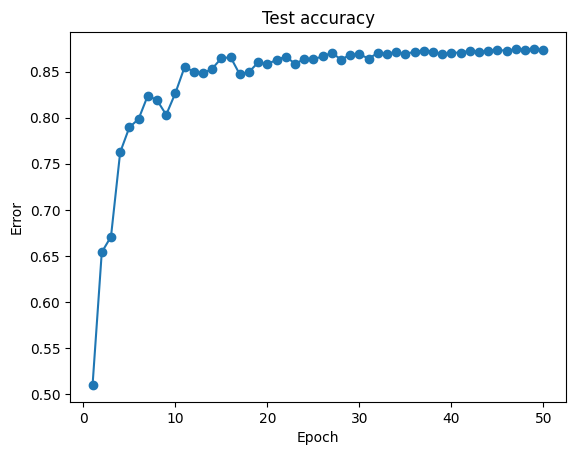

In [27]:
plt.plot(range(1, num_epochs+1), test_accuracy_list, marker='o')
plt.title("Test accuracy")
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()

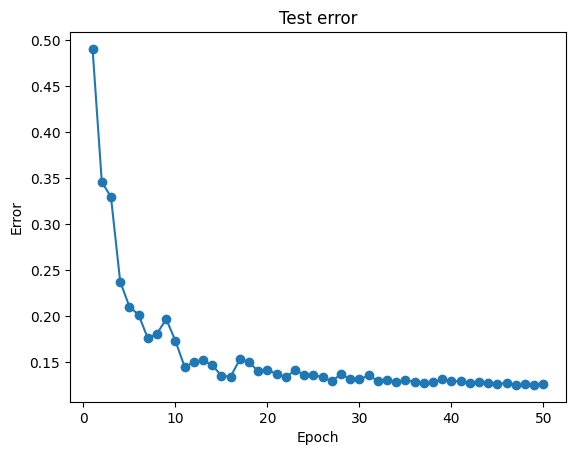

In [28]:
plt.plot(range(1, num_epochs+1), test_error_list, marker='o')
plt.title("Test error")
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()